## Telco Customer Churn Analysis

### Problem Statement
A telecom company is losing customers every month. This project analyzes customer data to:
- Identify key drivers of churn
- Build a machine learning model to predict which customers are at risk
- Provide actionable business recommendations to reduce churn

### Business Impact
**26% of customers are churning**, resulting in **$1.67M in annual revenue loss.**
A predictive model can help the business intervene before customers leave.

### Dataset
- **Source:** IBM Sample Dataset (Kaggle)
- **Size:** 7,043 customers, 21 features
- **Target Variable:** Churn (Yes/No)

## 1. Data Loading and Understanding

We load the Telco Customer Churn dataset and perform an initial inspection to understand:
- Dataset shape and structure
- Data types of each column
- Basic statistics
- Missing values

The dataset contains customer demographics, services subscribed, account information,
and whether the customer churned.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Read the csv file and load it into a dataframe called df
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Print shape of df, columns
print("Shape:", df.shape)
df.info()



Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

In [51]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Key Columns:**
- **Demographics:** gender, SeniorCitizen, Partner, Dependents
- **Services:** PhoneService, InternetService, OnlineSecurity, TechSupport, StreamingTV
- **Account:** tenure, Contract, PaymentMethod, MonthlyCharges, TotalCharges
- **Target:** Churn (Yes/No)

In [52]:
# understanding churn counts
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {df['Churn'].value_counts(normalize=True)['Yes']*100:.1f}%")

df['Churn'].value_counts(normalize=True)*100

Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.5%


Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

In [53]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [54]:
df['MonthlyCharges'].agg(['mean', 'median', 'std', 'min', 'max'])

mean       64.761692
median     70.350000
std        30.090047
min        18.250000
max       118.750000
Name: MonthlyCharges, dtype: float64

## 2. Data Cleaning

Real world data is never perfect. We identified and fixed the following issues:

**Issue 1 — TotalCharges data type:**
TotalCharges column was loaded as text (object) instead of numeric.
This happened because some rows contained blank spaces instead of numbers.

**Fix:** Used pd.to_numeric() with errors='coerce' to convert to float,
replacing blank spaces with NaN.

**Issue 2 — Missing Values:**
11 missing values appeared in TotalCharges after conversion.
These belong to new customers with no charges yet (tenure = 0).

**Fix:** Filled missing values with median instead of mean because
TotalCharges is right-skewed — median is more robust to outliers.

In [55]:
# TotalCharges was an object type, so converting it to float64 type, and filling the empty cells with median value
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].dtype)
print(df['TotalCharges'].isnull().sum())

df['TotalCharges'].agg(['mean', 'median', 'std'])
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

float64
11


## 3. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is the process of analyzing data to understand
its structure, patterns, and relationships before building models.

We answer three key questions:
1. What is the overall churn rate?
2. Which customer demographics are associated with higher churn?
3. Which services and account features predict churn?

In [56]:
df.groupby('Churn')['tenure'].mean()
#customers with low tenure are more likely to churn than customers with higher tenure

Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64

In [57]:
df.groupby('Churn')['MonthlyCharges'].mean()

Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64

In [58]:
df.groupby('Churn')['TotalCharges'].mean()

Churn
No     2552.882494
Yes    1531.796094
Name: TotalCharges, dtype: float64

In [59]:
df.groupby('Churn')['Contract'].value_counts(normalize=True)

Churn  Contract      
No     Month-to-month    0.429068
       Two year          0.318322
       One year          0.252609
Yes    Month-to-month    0.885500
       One year          0.088818
       Two year          0.025682
Name: proportion, dtype: float64

### 3.1 Correlation Analysis

Correlation measures the linear relationship between numeric features and churn.
Values range from -1 to +1:
- **Positive:** both variables increase together
- **Negative:** one increases as the other decreases
- **Close to 0:** weak relationship

In [60]:
#converting churn into 0 and 1 where 1 => churn and 0 => not churn
df['Churn_binary'] = (df['Churn'] == 'Yes').astype(int)
print(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_binary']].corr()['Churn_binary'].sort_values())

tenure           -0.352229
TotalCharges     -0.199037
MonthlyCharges    0.193356
Churn_binary      1.000000
Name: Churn_binary, dtype: float64


**Correlation with Churn:**

- **Tenure (-0.35):** Strongest relationship. Higher tenure = less churn.
- **TotalCharges (-0.20):** Negative because tied to tenure — long staying customers accumulate high charges.
- **MonthlyCharges (+0.19):** Higher monthly charges = more churn.

Tenure is the single strongest numeric predictor of churn.

In [61]:
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                    'PhoneService', 'InternetService', 'Contract', 
                    'PaymentMethod', 'OnlineSecurity', 'TechSupport']
for col in categorical_cols:
    churn_rate = df.groupby(col)['Churn_binary'].mean() * 100
    print(f"\n--- {col} ---")
    print(churn_rate.round(1))


--- gender ---
gender
Female    26.9
Male      26.2
Name: Churn_binary, dtype: float64

--- SeniorCitizen ---
SeniorCitizen
0    23.6
1    41.7
Name: Churn_binary, dtype: float64

--- Partner ---
Partner
No     33.0
Yes    19.7
Name: Churn_binary, dtype: float64

--- Dependents ---
Dependents
No     31.3
Yes    15.5
Name: Churn_binary, dtype: float64

--- PhoneService ---
PhoneService
No     24.9
Yes    26.7
Name: Churn_binary, dtype: float64

--- InternetService ---
InternetService
DSL            19.0
Fiber optic    41.9
No              7.4
Name: Churn_binary, dtype: float64

--- Contract ---
Contract
Month-to-month    42.7
One year          11.3
Two year           2.8
Name: Churn_binary, dtype: float64

--- PaymentMethod ---
PaymentMethod
Bank transfer (automatic)    16.7
Credit card (automatic)      15.2
Electronic check             45.3
Mailed check                 19.1
Name: Churn_binary, dtype: float64

--- OnlineSecurity ---
OnlineSecurity
No                     41.8
No interne

**Key Findings:**

| Feature | Finding |
|---|---|
| Gender | Not important — almost equal churn rate (26.9% vs 26.2%) |
| Senior Citizen | Important — seniors churn at 41.7% vs 23.6% for non-seniors |
| Partner | Important — single customers churn more (33% vs 19.7%) |
| Dependents | Important — customers without dependents churn more (31.3% vs 15.5%) |
| Phone Service | Not important — almost equal churn rate |
| Internet Service | Very important — fiber optic customers churn at 41.9% vs DSL 19% |
| Contract | Most important — month-to-month 42.7% vs two year 2.8% |
| Payment Method | Very important — electronic check 45.3% vs automatic ~16% |
| Online Security | Very important — no security 41.8% vs with security 14.6% |
| Tech Support | Very important — no support 41.6% vs with support 15.2% |

**Business Insight:** The highest risk customer profile is:
single, senior, fiber optic, month-to-month contract, electronic check payment,
with no online security or tech support.

## 4. Visualizations

Visual representations of our key findings make patterns immediately obvious
and communicate insights clearly to non-technical stakeholders.

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

# Professional style settings
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.titleweight'] = 'bold'

CHURN_COLORS = ['#2ecc71', '#e74c3c']  # green=no churn, red=churn
print("Setup done!")

Setup done!


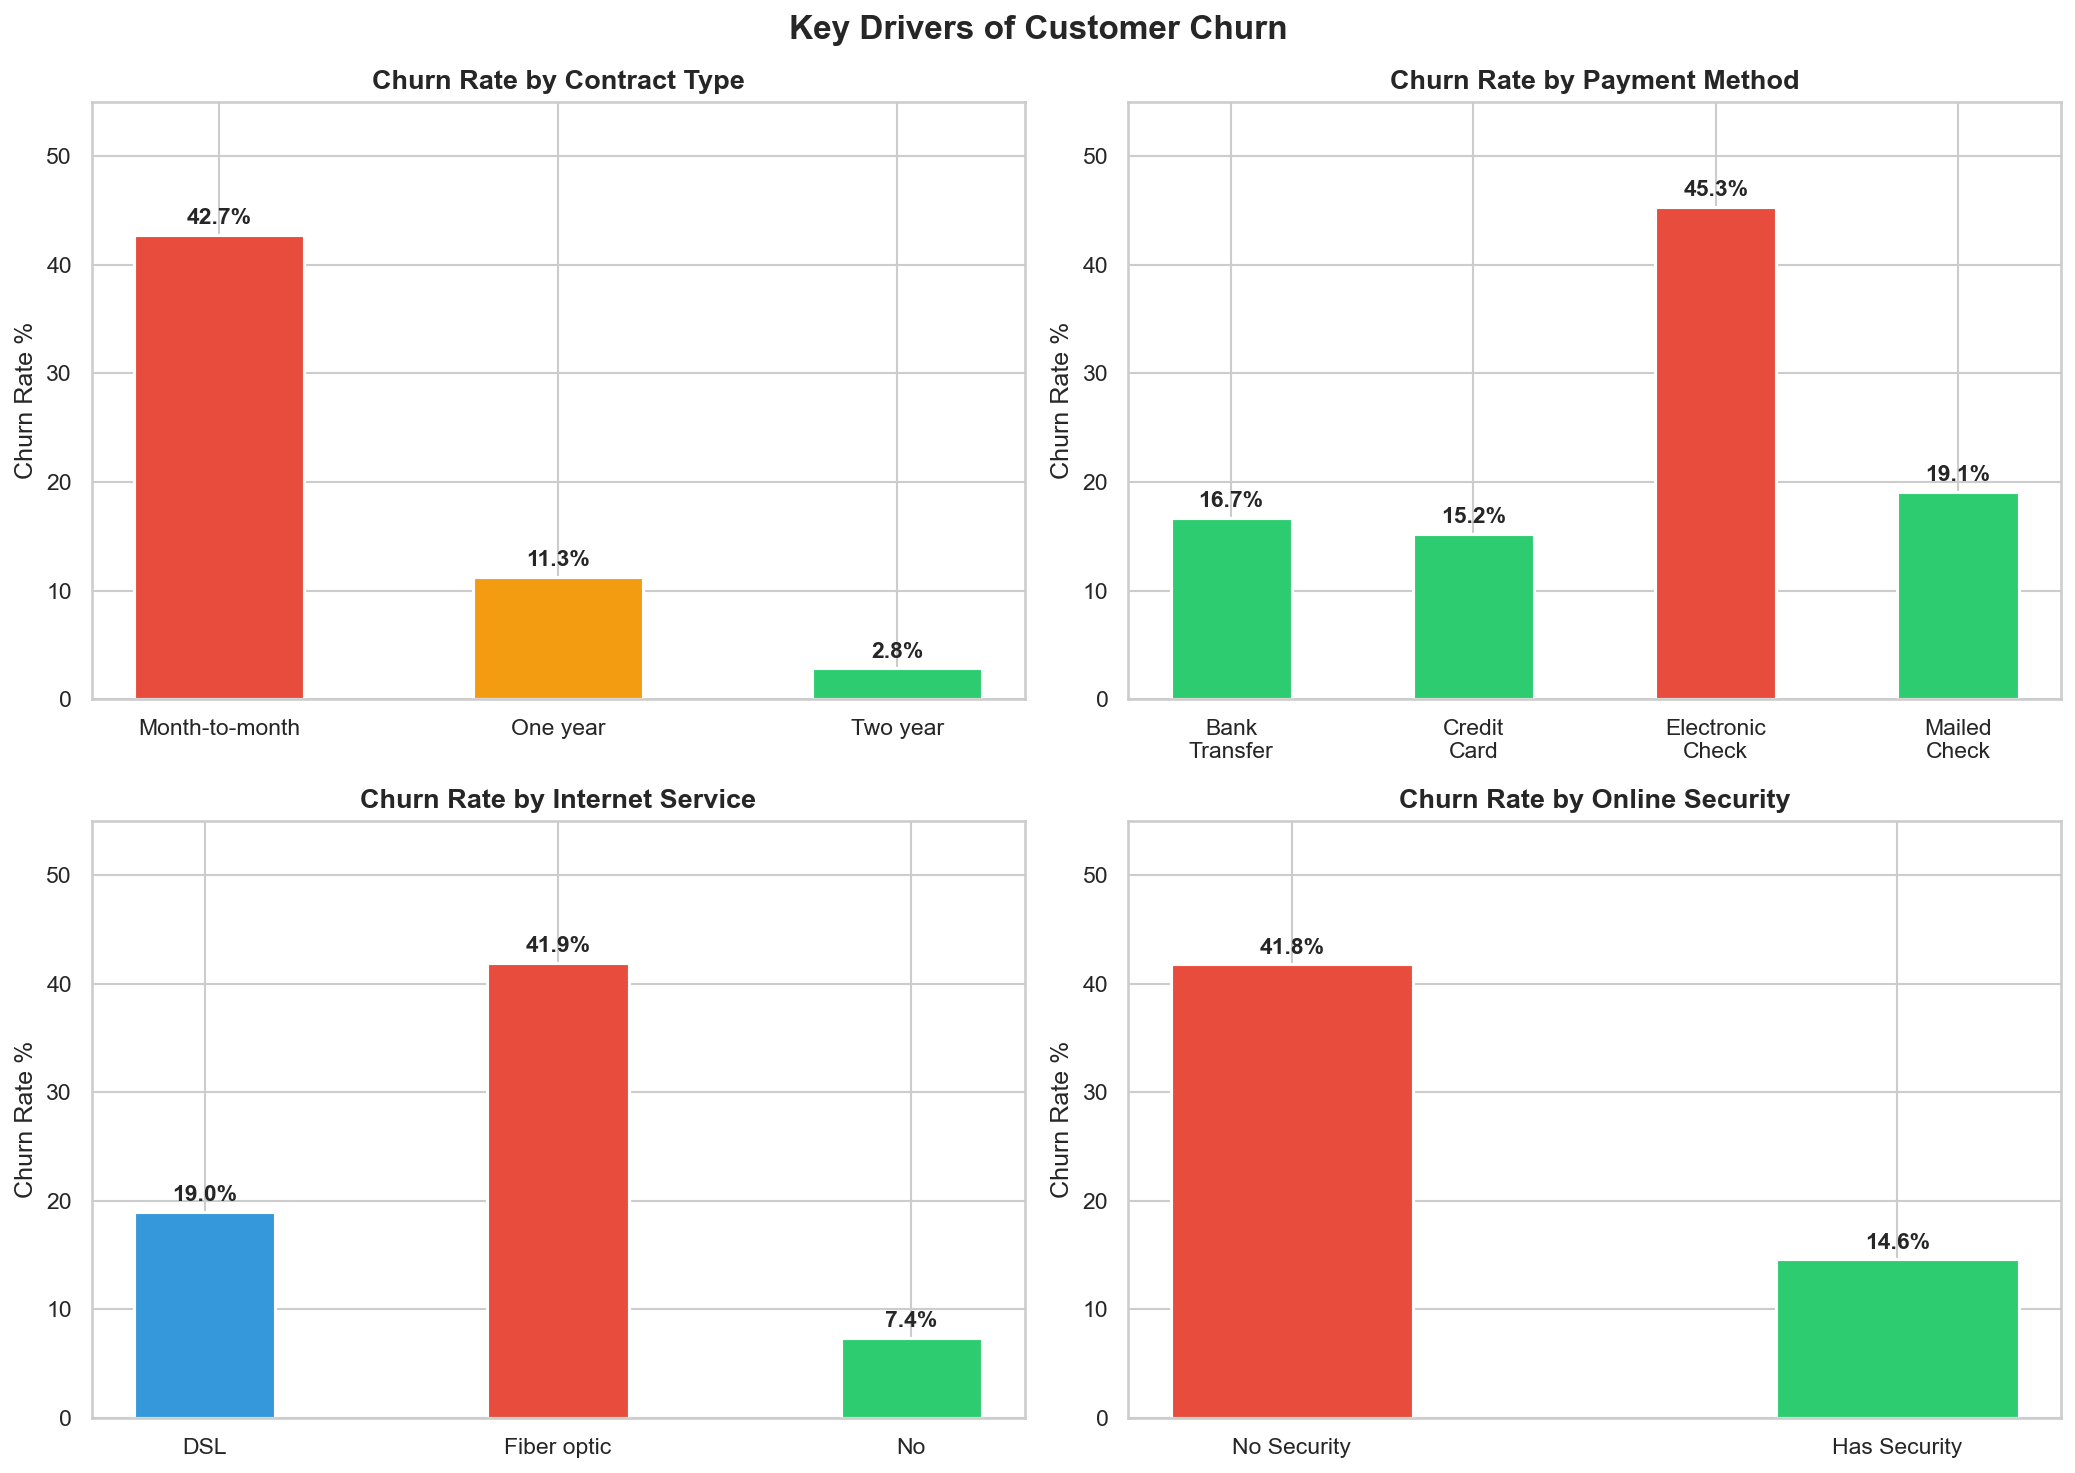

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Key Drivers of Customer Churn', fontsize=16, fontweight='bold')

# 1. Contract Type
contract_churn = df.groupby('Contract')['Churn_binary'].mean() * 100
bars = axes[0,0].bar(contract_churn.index, contract_churn.values,
                     color=['#e74c3c', '#f39c12', '#2ecc71'],
                     edgecolor='white', linewidth=1.5, width=0.5)
axes[0,0].set_title('Churn Rate by Contract Type')
axes[0,0].set_ylabel('Churn Rate %')
axes[0,0].set_ylim(0, 55)
for bar, val in zip(bars, contract_churn.values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)

# 2. Payment Method
payment_churn = df.groupby('PaymentMethod')['Churn_binary'].mean() * 100
short_labels = ['Bank\nTransfer', 'Credit\nCard', 'Electronic\nCheck', 'Mailed\nCheck']
bars2 = axes[0,1].bar(short_labels, payment_churn.values,
                      color=['#2ecc71', '#2ecc71', '#e74c3c', '#2ecc71'],
                      edgecolor='white', linewidth=1.5, width=0.5)
axes[0,1].set_title('Churn Rate by Payment Method')
axes[0,1].set_ylabel('Churn Rate %')
axes[0,1].set_ylim(0, 55)
for bar, val in zip(bars2, payment_churn.values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)

# 3. Internet Service
internet_churn = df.groupby('InternetService')['Churn_binary'].mean() * 100
bars3 = axes[1,0].bar(internet_churn.index, internet_churn.values,
                      color=['#3498db', '#e74c3c', '#2ecc71'],
                      edgecolor='white', linewidth=1.5, width=0.4)
axes[1,0].set_title('Churn Rate by Internet Service')
axes[1,0].set_ylabel('Churn Rate %')
axes[1,0].set_ylim(0, 55)
for bar, val in zip(bars3, internet_churn.values):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)

# 4. Online Security
security_churn = df[df['OnlineSecurity'] != 'No internet service'].groupby(
    'OnlineSecurity')['Churn_binary'].mean() * 100
bars4 = axes[1,1].bar(['No Security', 'Has Security'], security_churn.values,
                      color=['#e74c3c', '#2ecc71'],
                      edgecolor='white', linewidth=1.5, width=0.4)
axes[1,1].set_title('Churn Rate by Online Security')
axes[1,1].set_ylabel('Churn Rate %')
axes[1,1].set_ylim(0, 55)
for bar, val in zip(bars4, security_churn.values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('key_drivers.png', dpi=150, bbox_inches='tight')
plt.show()

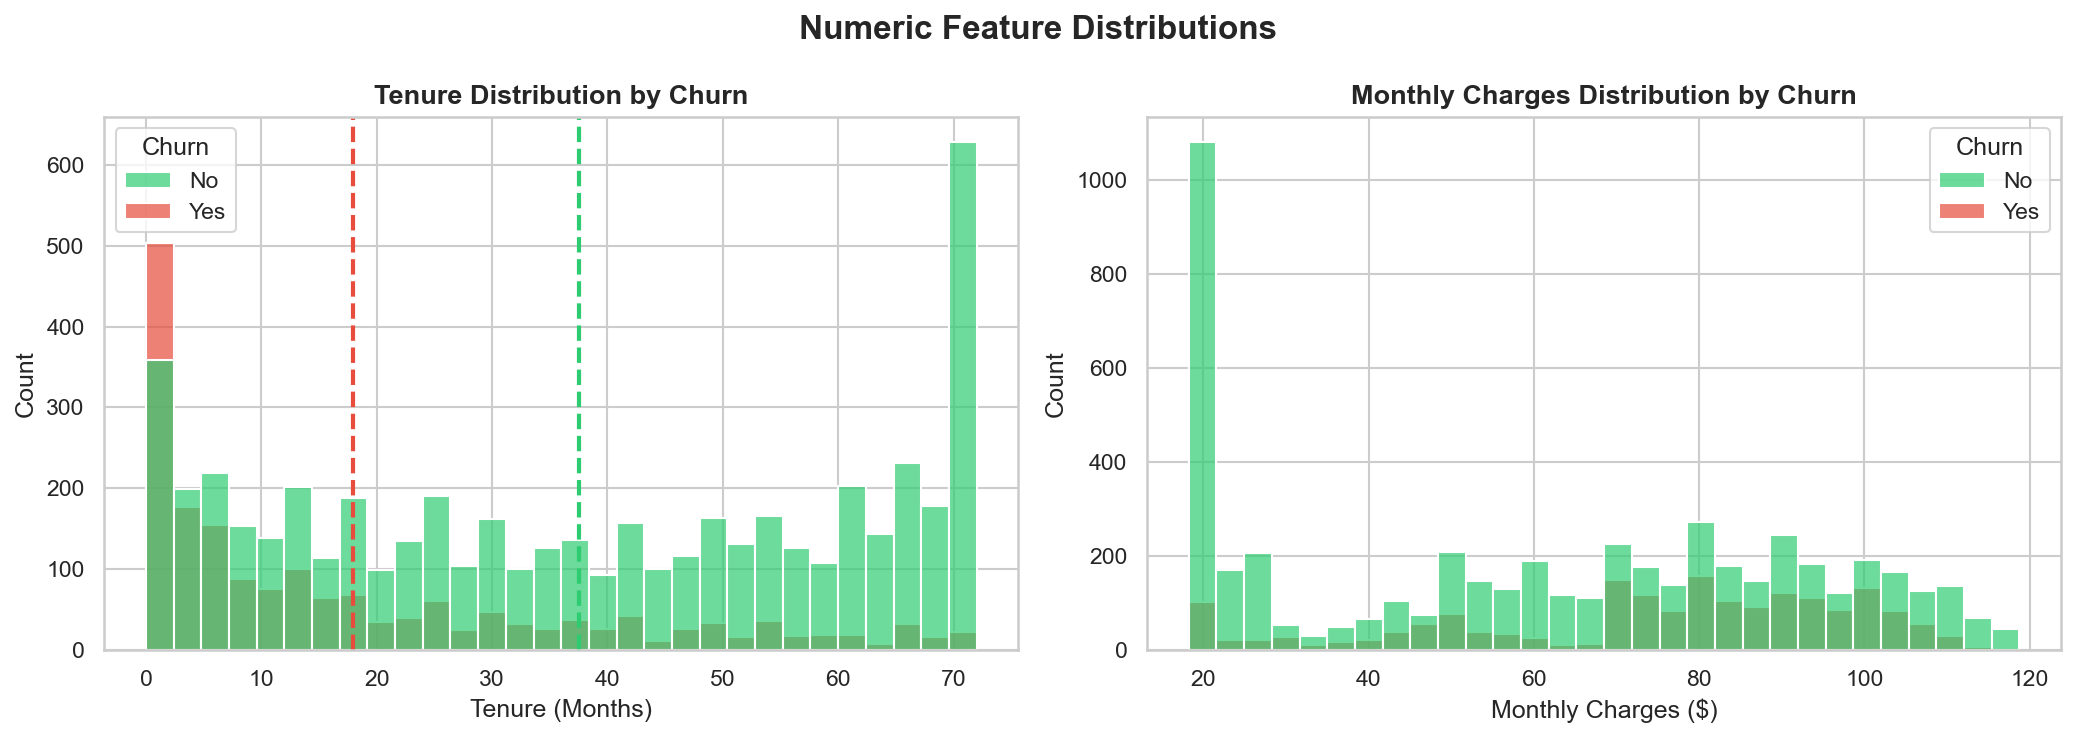

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Numeric Feature Distributions', fontsize=16, fontweight='bold')

# 1. Tenure
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, alpha=0.7,
             ax=axes[0], palette={'No': '#2ecc71', 'Yes': '#e74c3c'})
axes[0].set_title('Tenure Distribution by Churn')
axes[0].set_xlabel('Tenure (Months)')
axes[0].axvline(df[df['Churn']=='Yes']['tenure'].mean(),
                color='#e74c3c', linestyle='--', linewidth=2)
axes[0].axvline(df[df['Churn']=='No']['tenure'].mean(),
                color='#2ecc71', linestyle='--', linewidth=2)

# 2. Monthly Charges
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', bins=30, alpha=0.7,
             ax=axes[1], palette={'No': '#2ecc71', 'Yes': '#e74c3c'})
axes[1].set_title('Monthly Charges Distribution by Churn')
axes[1].set_xlabel('Monthly Charges ($)')

plt.tight_layout()
plt.savefig('numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

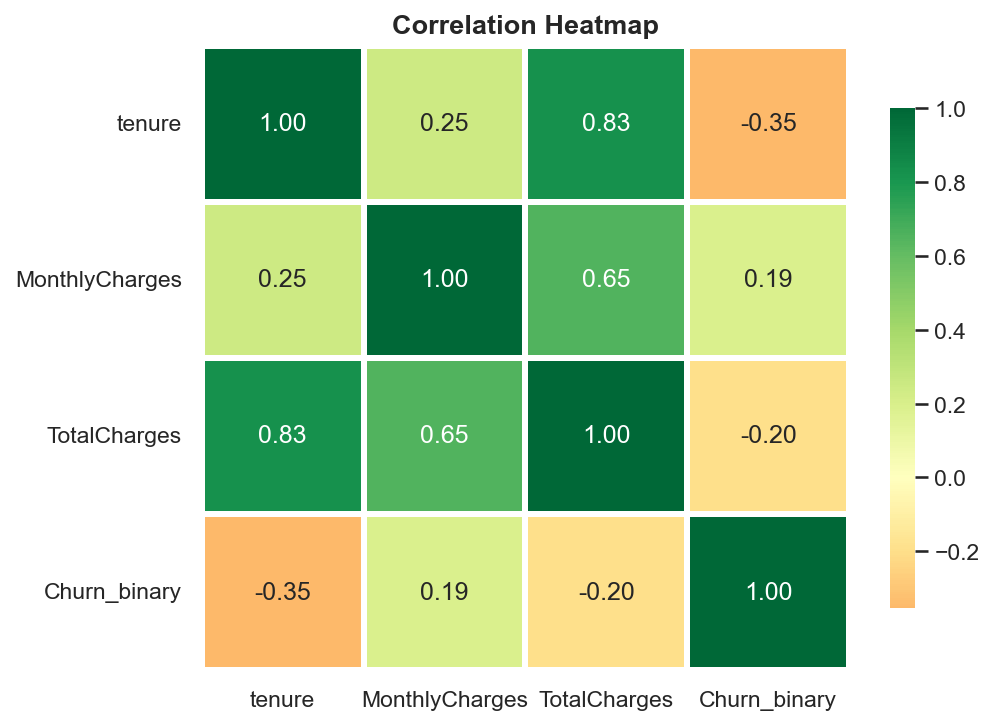

In [65]:
fig, ax = plt.subplots(figsize=(7, 5))

numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_binary']
corr_matrix = df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, ax=ax, linewidths=2,
            cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [66]:
df.shape

(7043, 22)

## 5. Feature Engineering

Machine learning models only understand numbers — they cannot process text categories
like "Month-to-month" or "Fiber optic."

**One Hot Encoding** converts categorical columns into binary (0/1) columns —
one column per category. This preserves the categorical nature without implying
false numerical relationships.

**drop_first=True** removes one category per feature to avoid multicollinearity —
the dropped category is implied when all other columns are 0.

Result: dataset expanded from 18 features to 30 after encoding.

In [67]:
# Start fresh from original dataframe, dropping all churn related columns
df_model = df.drop(['customerID', 'Churn', 'Churn_binary'], axis=1)

# One hot encode
df_model = pd.get_dummies(df_model, drop_first=True)

# Check columns
print(df_model.columns.tolist())
print(df_model.shape)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
(7043, 30)


In [68]:
# Our target variable (dependent variables)
y = (df['Churn'] == 'Yes').astype(int)

# Our features (independent variables)
X = df_model

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Churn distribution:", y.value_counts())

X shape: (7043, 30)
y shape: (7043,)
Churn distribution: Churn
0    5174
1    1869
Name: count, dtype: int64


## 6. Model Building

We build and compare 6 classification models to predict customer churn.

**Approach:**
- Start with Logistic Regression as baseline
- Progress to more complex models
- Address class imbalance with balanced class weights
- Evaluate using ROC-AUC (primary) and Recall for churners (business metric)

**Why Recall matters most:**
Missing a churner means losing a customer forever.
A false alarm just means offering a retention deal to someone who wasn't leaving.
The cost of missing a churner is much higher.

### 6.1 Logistic Regression (Baseline)

Logistic Regression predicts the probability of churn using a sigmoid function
that converts any input into a value between 0 and 1.

It learns weights for each feature through gradient descent — minimizing
Binary Cross Entropy loss function.

We use this as our **baseline** — the minimum performance any model should beat.

In [69]:
# Applying Logistic Regression on data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print("Logistic Regression: \n")
# Evaluate
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 3))

Logistic Regression: 

Accuracy: 0.822

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409

ROC-AUC Score: 0.862


**Results:** Accuracy 0.822, ROC-AUC 0.862.

Strong baseline performance. However recall for churners is only 0.60 —
we're missing 40% of customers about to leave.

**Root cause:** Class imbalance. With 3x more non-churners, the model is biased
toward predicting No Churn. We address this next with balanced class weights.

### 6.2 Balanced Logistic Regression

Class imbalance causes the model to ignore the minority class (churners).
Setting class_weight='balanced' assigns higher importance to churners:

- Non-churn weight = 0.68
- Churn weight = 1.88

Each churner now counts as 1.88x more important during training,
forcing the model to pay more attention to them.

In [70]:
# Balanced model: By telling the model to treat churners as more important than non churners
model_balanced = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model_balanced.fit(X_train, y_train)

y_pred_balanced = model_balanced.predict(X_test)
print("Balanced Logistic Regression results: \n")
print("Accuracy:", round(accuracy_score(y_test, y_pred_balanced), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced))
print("ROC-AUC Score:", round(roc_auc_score(y_test, model_balanced.predict_proba(X_test)[:,1]), 3))

Balanced Logistic Regression results: 

Accuracy: 0.752

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1036
           1       0.52      0.84      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.75      0.77      1409

ROC-AUC Score: 0.862


**Results:** ROC-AUC 0.862, Recall 0.84.

Recall jumped from 0.60 to 0.84 — we now catch 84% of churners.
ROC-AUC stayed the same — overall discrimination ability unchanged.

This is the **precision-recall tradeoff** — higher recall comes at the cost
of lower precision. For our business problem, this tradeoff is worth it.

### 6.3 Decision Tree (Unbalanced)

A Decision Tree makes predictions by asking a series of yes/no questions
about features, splitting data at each node based on Gini Impurity.

It selects the feature with the highest Information Gain at each split —
the feature that creates the purest groups of churners and non-churners.

In [71]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state = 42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("Decision Tree Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_dt), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC Score:", round(roc_auc_score(y_test, dt_model.predict_proba(X_test)[:,1]), 3))

Decision Tree Results:
Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1036
           1       0.45      0.45      0.45       373

    accuracy                           0.71      1409
   macro avg       0.63      0.63      0.63      1409
weighted avg       0.71      0.71      0.71      1409

ROC-AUC Score: 0.629


**Results:** Accuracy 0.710, ROC-AUC 0.629.

Poor performance — barely better than random guessing (0.5 ROC-AUC).

**Root cause: Overfitting.** The tree grew until every leaf was pure,
memorizing training data including noise. Training accuracy was ~99%
while test accuracy was 71% — a 28% gap proving overfitting.

We fix this next by constraining the tree's growth.

In [72]:
y_pred_train = dt_model.predict(X_train)
print("Training Accuracy:", round(accuracy_score(y_train, y_pred_train), 3))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_dt), 3))

Training Accuracy: 0.999
Test Accuracy: 0.71


Training Accuracy 0.999 is much higher than Test Accuracy 0.71, making is a case of overfitting. This can be resolved my limiting max_depth of a tree. 

### 6.4 Balanced Decision Tree

We prevent overfitting using three constraints:
- **max_depth=5:** Stop after 5 levels
- **min_samples_split=20:** Don't split nodes with fewer than 20 customers
- **min_samples_leaf=10:** Each leaf must have at least 10 customers

Plus class_weight='balanced' to address class imbalance.

In [73]:
dt_model_balanced = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

dt_model_balanced.fit(X_train, y_train)
y_pred_dt_balanced = dt_model_balanced.predict(X_test)
print("Balanced Decision Tree results:\n")
# Check overfitting
y_pred_train_balanced = dt_model_balanced.predict(X_train)
print("Training Accuracy:", round(accuracy_score(y_train, y_pred_train_balanced), 3))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_dt_balanced), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt_balanced))
print("ROC-AUC:", round(roc_auc_score(y_test, dt_model_balanced.predict_proba(X_test)[:,1]), 3))

Balanced Decision Tree results:

Training Accuracy: 0.753
Test Accuracy: 0.745

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1036
           1       0.51      0.79      0.62       373

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409

ROC-AUC: 0.836


**Results:** Training 0.753, Test 0.745, ROC-AUC 0.836, Recall 0.79.

Overfitting solved — training and test accuracy are almost identical (0.008 gap).
ROC-AUC improved from 0.629 to 0.836. Recall jumped from 0.45 to 0.79.

Significant improvement but still behind Logistic Regression on ROC-AUC.

### 6.5 Random Forest

Random Forest fixes Decision Tree's instability by building 200 diverse trees
and combining their predictions through majority voting.

Diversity is created through two mechanisms:
- **Bootstrapping:** Each tree trains on a random sample of data with replacement
- **Feature randomness:** Each split considers only √30 ≈ 5-6 random features

Individual tree errors are uncorrelated and cancel out when averaged —
resulting in much lower variance than a single tree.

In [74]:
from sklearn.ensemble import RandomForestClassifier

# Build Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200, #build 200 trees
    max_depth = 10, #max_height of a tree
    max_features='sqrt', #At each split consider only 30^0.5 features
    oob_score=True, #Use Out of Bag samples to evaluate each tree for free
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", round(roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]), 3))
print("OOB Score:", round(rf_model.oob_score_, 3))

Random Forest Results:
Accuracy: 0.793

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1036
           1       0.58      0.77      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.79      0.76      1409
weighted avg       0.82      0.79      0.80      1409

ROC-AUC: 0.864
OOB Score: 0.774


**Results:** Accuracy 0.793, ROC-AUC 0.864, Recall 0.77, OOB Score 0.774.

Best ROC-AUC so far at 0.864 — Random Forest's ensemble approach
outperforms all previous models on overall discrimination ability.

OOB Score of 0.774 provides a reliable performance estimate using
the 37% of data not seen by each tree during training.

XGBoost (Extreme Gradient Boosting) builds trees sequentially — each tree learns from the mistakes of the previous one through residuals.

### 6.6 XGBoost

XGBoost builds trees **sequentially** — each tree learns from the residuals
(errors) of all previous trees. This is fundamentally different from Random Forest
which builds trees independently.

**Process:**
1. Start with base prediction (average churn rate)
2. Calculate residuals (actual - predicted)
3. Build tree to predict residuals
4. Update predictions: new = old + (learning_rate × tree prediction)
5. Repeat until early stopping triggers

Early stopping automatically finds the optimal number of trees (59 in our case)
preventing overfitting without manual tuning.

In [75]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5174/1869,
    early_stopping_rounds=50,
    eval_metric='auc',
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Results:")
print("Best iteration:", xgb_model.best_iteration)
print("Accuracy:", round(accuracy_score(y_test, y_pred_xgb), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", round(roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]), 3))

XGBoost Results:
Best iteration: 59
Accuracy: 0.755

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1036
           1       0.52      0.84      0.65       373

    accuracy                           0.76      1409
   macro avg       0.73      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409

ROC-AUC: 0.863


**Results:** Best iteration 59, Accuracy 0.755, ROC-AUC 0.863, Recall 0.84.

Early stopping found optimal performance at just 59 trees out of 1000 maximum.
Recall of 0.84 ties with Balanced Logistic Regression — both catch 84% of churners.

Despite being a more complex algorithm, XGBoost does not significantly
outperform simpler models — confirming our data has mostly linear relationships.

## 7. Model Comparison

| Model | Accuracy | ROC-AUC | Recall (Churners) |
|---|---|---|---|
| Logistic Regression | 0.822 | 0.862 | 0.60 |
| Logistic Regression (Balanced) | 0.752 | 0.862 | 0.84 |
| Decision Tree (Overfit) | 0.710 | 0.629 | 0.45 |
| Decision Tree (Balanced) | 0.745 | 0.836 | 0.79 |
| Random Forest | 0.793 | 0.864 | 0.77 |
| XGBoost | 0.755 | 0.863 | 0.84 |

**Winner: Balanced Logistic Regression for deployment**
- Ties best ROC-AUC (0.862)
- Ties best Recall (0.84)
- Most interpretable — easy to explain to business stakeholders
- Fastest — suitable for real time prediction

**Key insight:** Complex models (Random Forest, XGBoost) did not significantly
outperform simple Balanced Logistic Regression — confirming churn has
mostly linear relationships in this dataset.

### 7.1 Model Performance Visualization

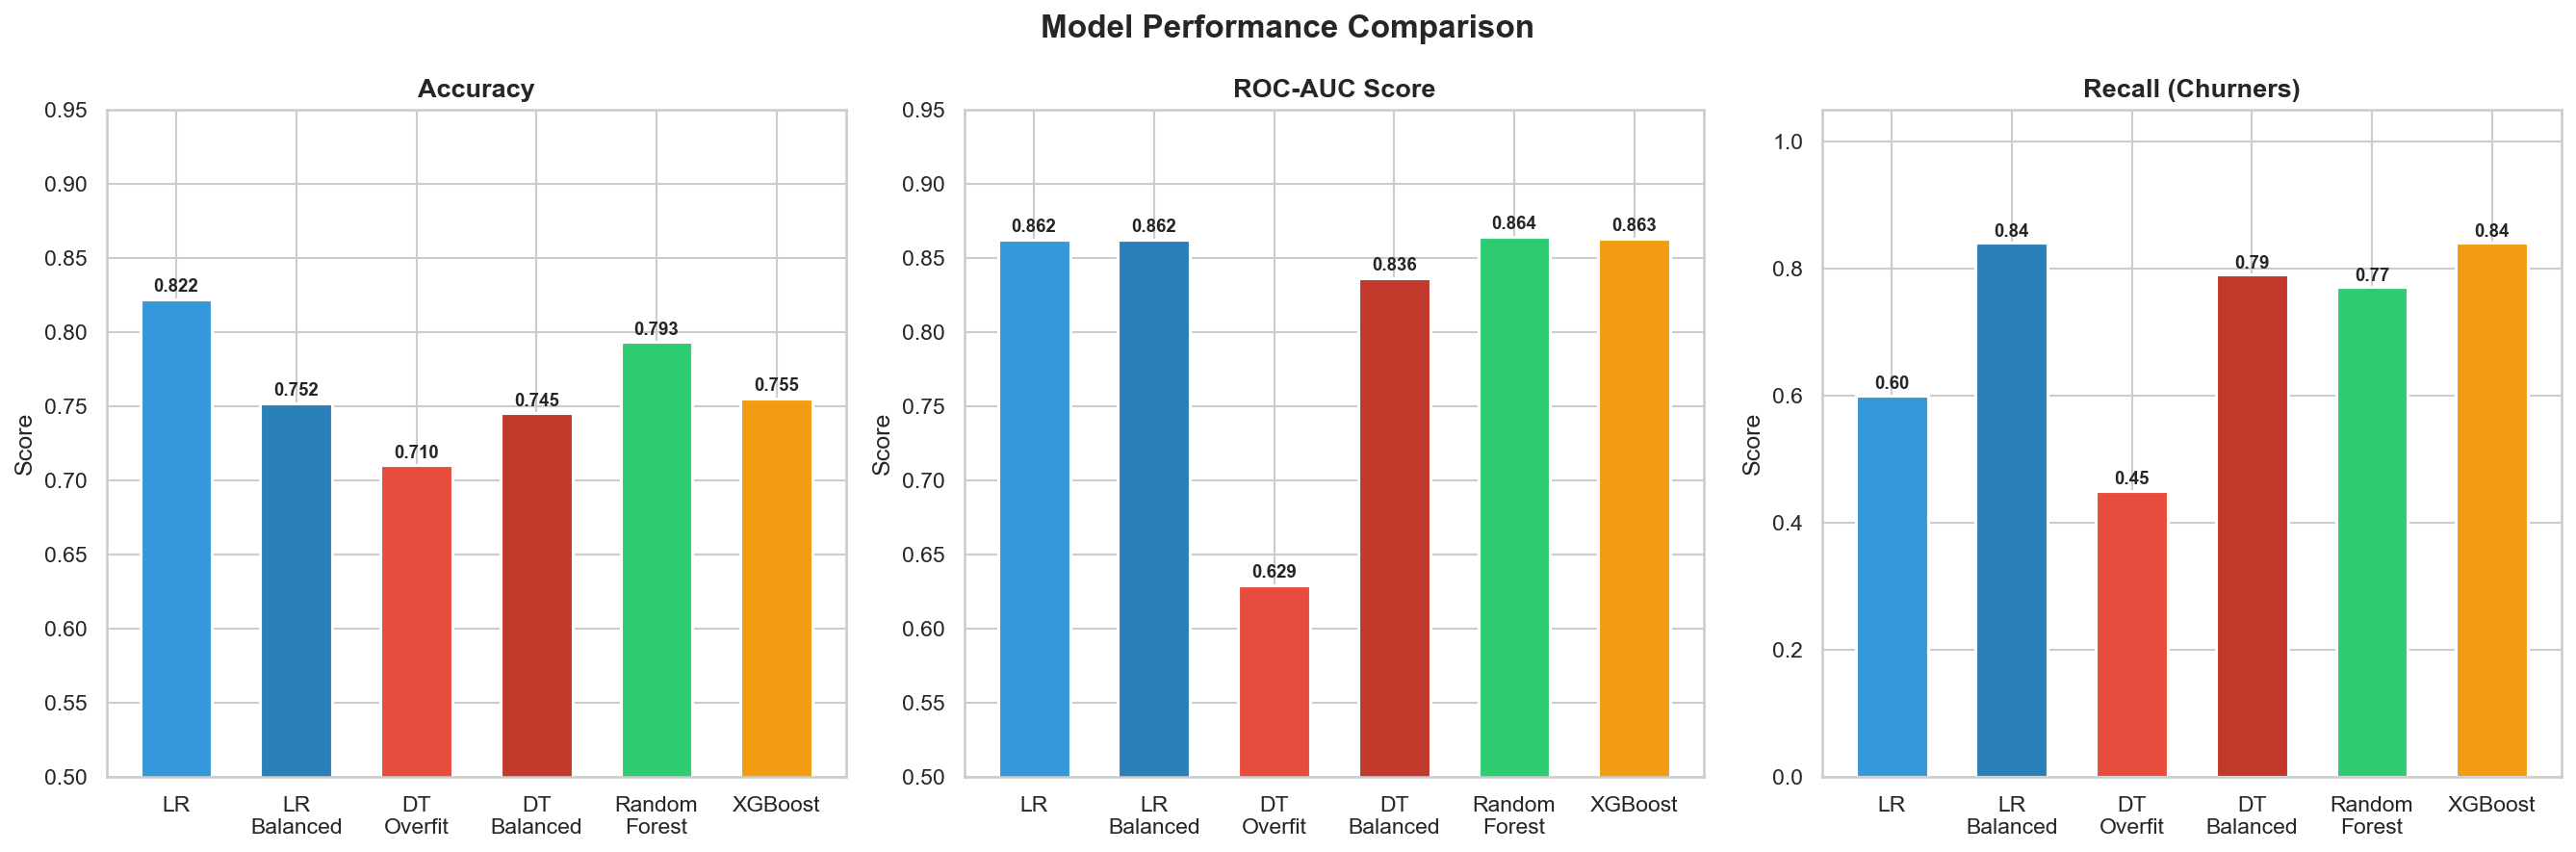

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

models = ['LR', 'LR\nBalanced', 'DT\nOverfit', 'DT\nBalanced', 'Random\nForest', 'XGBoost']
accuracy = [0.822, 0.752, 0.710, 0.745, 0.793, 0.755]
roc_auc = [0.862, 0.862, 0.629, 0.836, 0.864, 0.863]
recall = [0.60, 0.84, 0.45, 0.79, 0.77, 0.84]
colors = ['#3498db', '#2980b9', '#e74c3c', '#c0392b', '#2ecc71', '#f39c12']

# 1. Accuracy
bars = axes[0].bar(models, accuracy, color=colors, edgecolor='white', linewidth=1.5, width=0.6)
axes[0].set_title('Accuracy')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0.5, 0.95)
for bar, val in zip(bars, accuracy):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.3f}', ha='center', fontweight='bold', fontsize=9)

# 2. ROC-AUC
bars2 = axes[1].bar(models, roc_auc, color=colors, edgecolor='white', linewidth=1.5, width=0.6)
axes[1].set_title('ROC-AUC Score')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0.5, 0.95)
for bar, val in zip(bars2, roc_auc):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.3f}', ha='center', fontweight='bold', fontsize=9)

# 3. Recall
bars3 = axes[2].bar(models, recall, color=colors, edgecolor='white', linewidth=1.5, width=0.6)
axes[2].set_title('Recall (Churners)')
axes[2].set_ylabel('Score')
axes[2].set_ylim(0, 1.05)
for bar, val in zip(bars3, recall):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{val:.2f}', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Feature Importance

Feature importance tells us which customer attributes drive churn most.
We compare Random Forest and XGBoost importance scores to identify
consistent signals across both models.

Features appearing in both models' top 10 are the most reliable predictors.

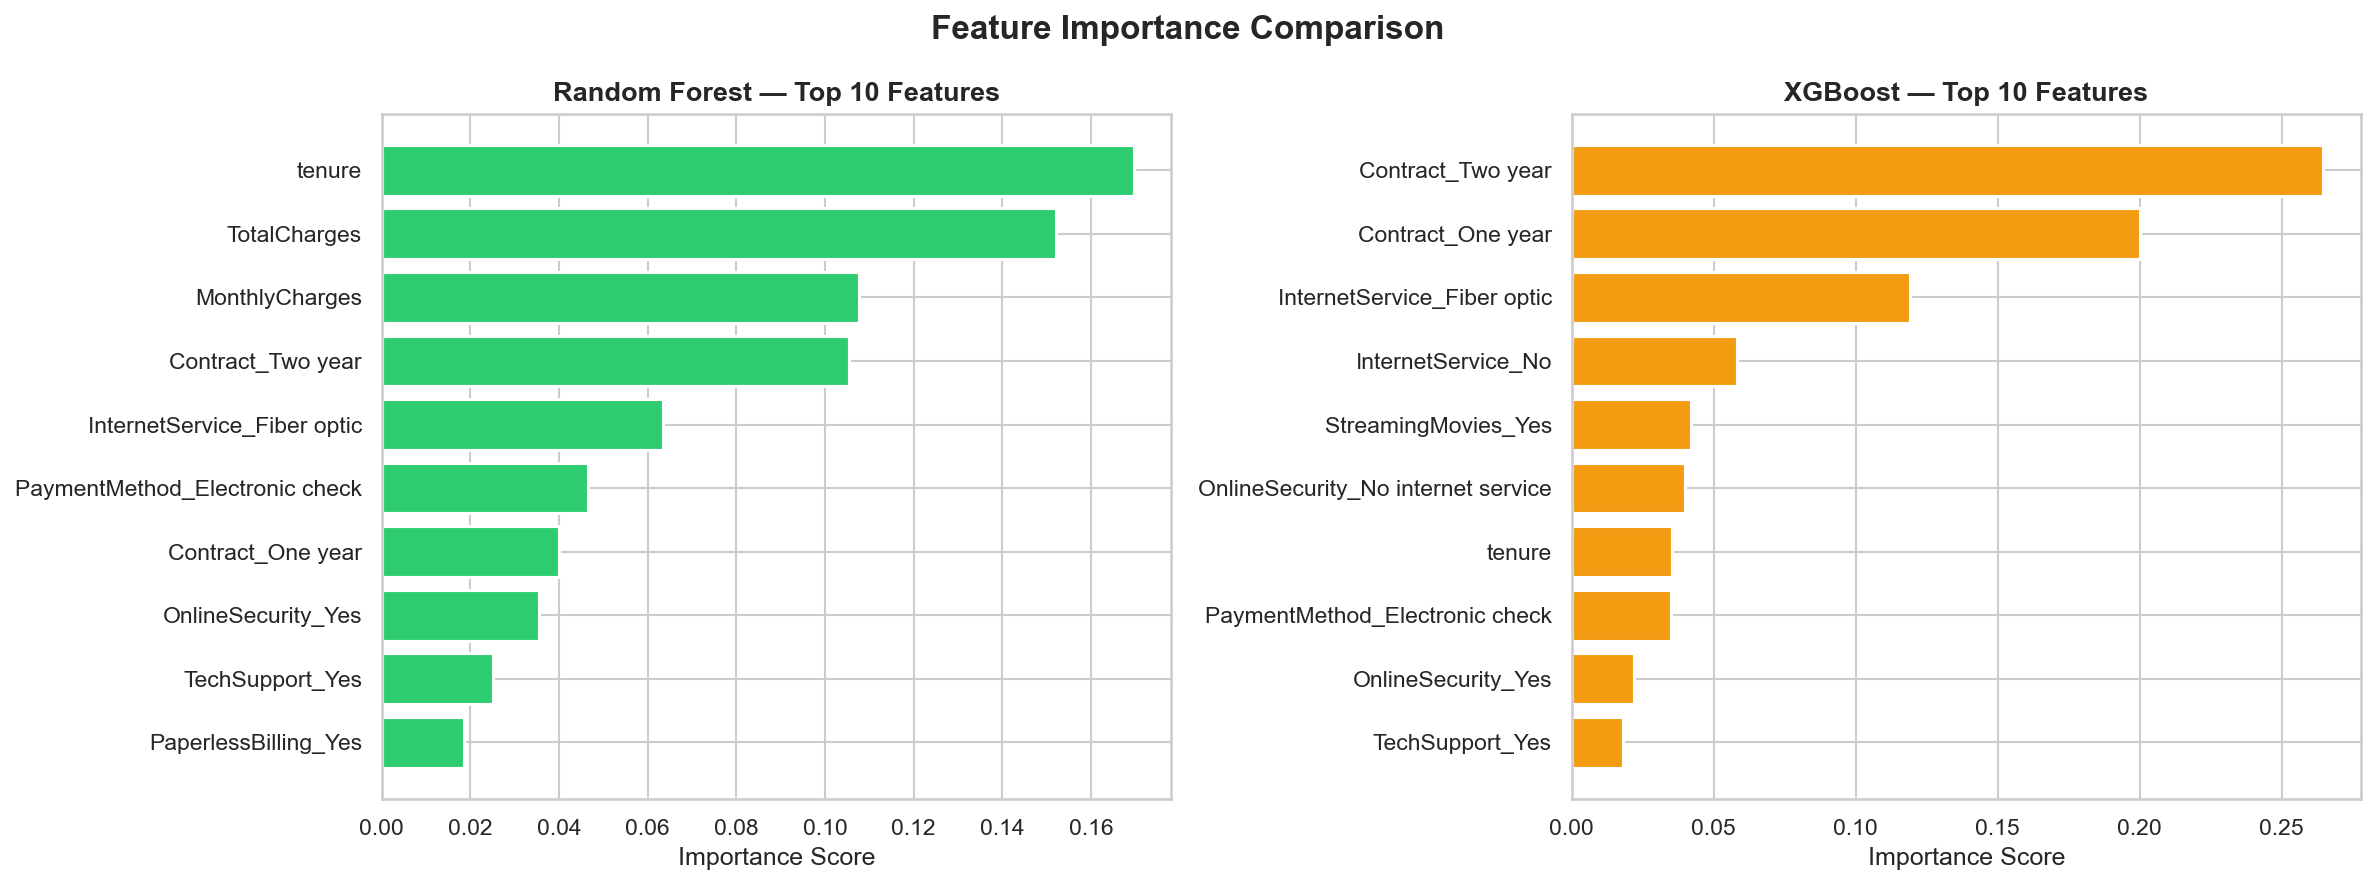

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance Comparison', fontsize=16, fontweight='bold')

# Random Forest
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(10)

axes[0].barh(rf_importance['Feature'], rf_importance['Importance'],
             color='#2ecc71', edgecolor='white', linewidth=1.5)
axes[0].set_title('Random Forest — Top 10 Features')
axes[0].set_xlabel('Importance Score')

# XGBoost
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(10)

axes[1].barh(xgb_importance['Feature'], xgb_importance['Importance'],
             color='#f39c12', edgecolor='white', linewidth=1.5)
axes[1].set_title('XGBoost — Top 10 Features')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

**Key Findings:**

**Consistent across both models:**
- Contract type (One year, Two year) — strongest predictor
- Internet Service (Fiber optic) — high churn risk
- Payment Method (Electronic check) — manual payers churn more
- Online Security — customers without it churn more

**Model specific:**
- Random Forest prioritizes tenure
- XGBoost prioritizes contract type
- Both capture the same underlying pattern — tenure and contract are correlated

**Business implication:** Focus retention on fiber optic, month-to-month,
electronic check customers without online security.

In [78]:
# Revenue impact analysis
churned = df[df['Churn'] == 'Yes']
monthly_revenue_lost = churned['MonthlyCharges'].sum()
annual_revenue_lost = monthly_revenue_lost * 12

print(f"Monthly revenue lost to churn: ${monthly_revenue_lost:,.0f}")
print(f"Annual revenue lost to churn: ${annual_revenue_lost:,.0f}")
print(f"Average monthly charge of churned customer: ${churned['MonthlyCharges'].mean():,.2f}")

Monthly revenue lost to churn: $139,131
Annual revenue lost to churn: $1,669,570
Average monthly charge of churned customer: $74.44


## 9. Business Recommendations

Every recommendation below is directly backed by data from our analysis.

---

### Recommendation 1 — Onboarding Retention Program
**Finding:** Churners have average tenure of 18 months vs 38 for non-churners.
New customers are highest risk in first 12 months.

**Action:** Assign dedicated account managers to new customers.
Send check-in communications at months 1, 3, and 6.
Offer loyalty discount after 6 months.

---

### Recommendation 2 — Incentivize Long Term Contracts
**Finding:** Month-to-month churn rate 42.7% vs two year 2.8%.

**Action:** Offer 1-2 months free when signing annual contract.
Provide price lock guarantee for 2 year contracts.
Show customers total savings upfront.

---

### Recommendation 3 — Auto-Pay Enrollment Campaign
**Finding:** Electronic check customers churn at 45.3% vs ~16% for auto-pay.

**Action:** Offer $5/month discount for switching to automatic payment.
Run targeted campaign for all electronic check users.

---

### Recommendation 4 — Fiber Optic Customer Satisfaction
**Finding:** Fiber optic customers churn at 41.9% vs DSL 19%.

**Action:** Survey fiber optic customers about satisfaction.
Compare pricing with competitors.
Offer introductory pricing for first 6 months.

---

### Recommendation 5 — Bundle Security and Support
**Finding:** Customers without Online Security and Tech Support churn at ~41%
vs ~15% with these services.

**Action:** Offer free 3 month trial of Online Security to customers without it.
Bundle Tech Support into higher tier plans.

---

### Revenue Impact
**Annual revenue at risk: $1,669,570**
**Average monthly charge of churned customer: $74.44**

Even reducing churn by 10% through these interventions would recover
approximately **$167,000 in annual revenue.**